# Quality Control
## Sample-level QC
A useful initial step in an RNA-seq analysis is often to assess overall similarity between samples:

- Which samples are similar to each other, which are different?

- Does this fit to the expectation from the experiment’s design?

- What are the major sources of variation in the dataset?


For more information: https://hbctraining.github.io/Training-modules/planning_successful_rnaseq/lessons/sample_level_QC.html

In [55]:
library(ggplot2)
library(DESeq2)
library(pheatmap)
library(reshape2)

In [30]:
count_file="./matrix.tsv.gz"
condition_file="./condition.txt"

In [96]:
count <- read.delim(count_file,header=TRUE,sep='\t',row.names=1)
head(count)

,P_1_2,P_20_1,P_20_2,P_20_3,P_1_1,B_50_3,P_20_4,B_50_4,B_50_5,P_20_5,⋯,B_10_5,B_10_6,B_20_1,B_20_2,B_20_3,B_20_4,B_20_5,B_20_6,B_50_1,B_50_2
ENSG00000000003,6,12,2,12,5,2,7,4,7,11,⋯,6,5,5,9,8,2,7,5,3,2
ENSG00000000419,1,2,0,10,2,1,3,3,5,4,⋯,0,3,3,5,0,2,3,1,1,0
ENSG00000000457,0,0,0,0,0,0,0,0,1,2,⋯,0,0,0,0,0,2,0,0,0,0
ENSG00000000460,0,0,0,0,1,0,0,0,0,0,⋯,0,0,1,1,0,0,0,1,0,1
ENSG00000000971,0,4,3,5,2,0,1,2,2,10,⋯,0,0,1,2,3,0,1,1,2,0
ENSG00000001036,5,7,4,8,9,3,3,3,5,7,⋯,0,6,7,4,7,1,3,5,4,1


In [95]:
# The "sample" column is the same as the column name of the expression matrix
metadata <- read.delim(condition_file,header=TRUE,sep='\t')
head(metadata)

sample,group
B_10_1,B_10
B_10_2,B_10
B_10_3,B_10
B_10_4,B_10
B_10_5,B_10
B_10_6,B_10


In [33]:
countdata <- count[rowSums(count)>1,]
samples=as.character(metadata$sample)
countdata<-subset(countdata,select=samples)

### Normalized counts with DESeq2

In [34]:
dds <- DESeqDataSetFromMatrix(countData=countdata,colData=metadata,design=~sample)

#### Median of ratios method of normalization

In [45]:
dds <- estimateSizeFactors(dds)
normalized_counts <- counts(dds, normalized=TRUE)

In [46]:
normalized_counts[1:5,1:5]

,B_10_1,B_10_2,B_10_3,B_10_4,B_10_5
ENSG00000000003,8.030016,1.126817,3.199337,8.411194,12.39594
ENSG00000000419,5.353344,1.126817,4.265783,4.205597,0.00000
ENSG00000000457,0.000000,1.126817,2.132892,0.000000,0.00000
ENSG00000000460,0.000000,0.000000,1.066446,1.401866,0.00000
ENSG00000000971,1.338336,2.253634,1.066446,0.000000,0.00000


In [82]:
data <- log2(normalized_counts+1)
data <- melt(data)
colnames(data)<-c("gene","sample","value")
data <- merge(data,metadata,by='sample')
colnames(data) <- c("sample","gene","value","group")
head(data)

sample,gene,value,group
B_1_1,ENSG00000000003,2.210384,B_1
B_1_1,ENSG00000000419,2.210384,B_1
B_1_1,ENSG00000000457,0.000000,B_1
B_1_1,ENSG00000000460,0.000000,B_1
B_1_1,ENSG00000000971,0.000000,B_1
B_1_1,ENSG00000001036,2.210384,B_1


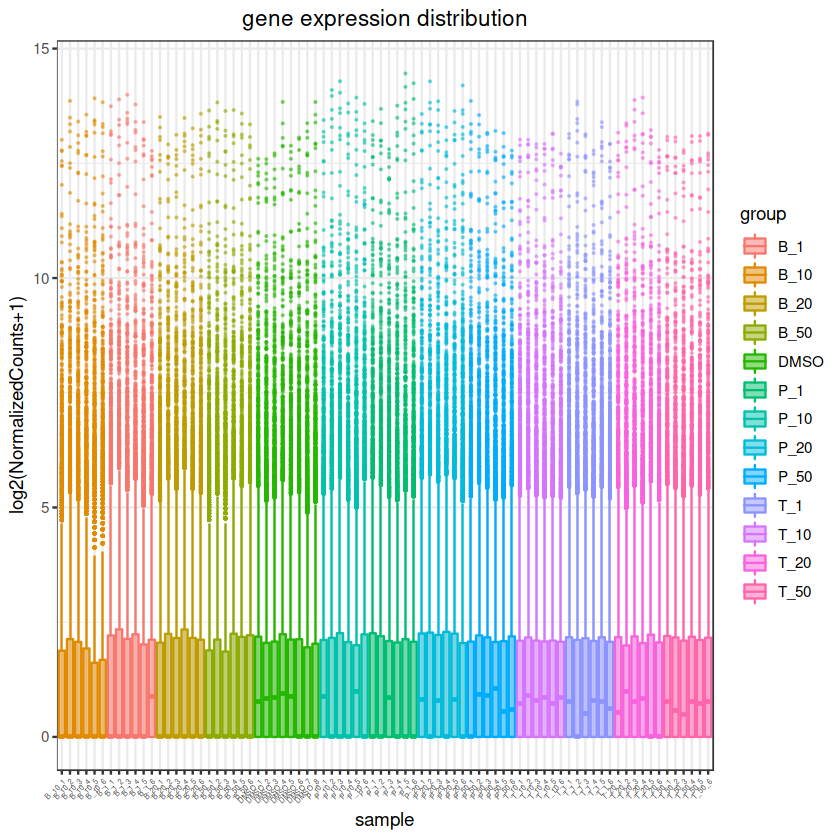

In [94]:
p <- ggplot(data,aes(x=sample,y=value,colour=group,fill=group)) +
    geom_boxplot(alpha=0.5,outlier.size=0.1) +
    xlab("sample") +
    ylab("log2(NormalizedCounts+1)") +
    labs(title="gene expression distribution") +
    theme_bw() +
    theme(axis.text.x=element_text(hjust=1,angle=45,size=4)) +
    theme(plot.title=element_text(hjust=0.5))
p

#### Transform normalized counts
The rlog transformation of the normalized counts is only necessary for these visualization methods during this quality assessment. We will not be using these tranformed counts for determining differential expression.

If the sample size is greater than 50, please use vst instead of rlog.

In [47]:
rld <- vst(dds, blind=TRUE)

### Principal component analysis (PCA) 
Principal Component Analysis (PCA) is a technique used to emphasize variation and bring out strong patterns in a dataset (dimensionality reduction). This is a very important technique used in the QC and analysis of both bulk and single-cell RNAseq data.

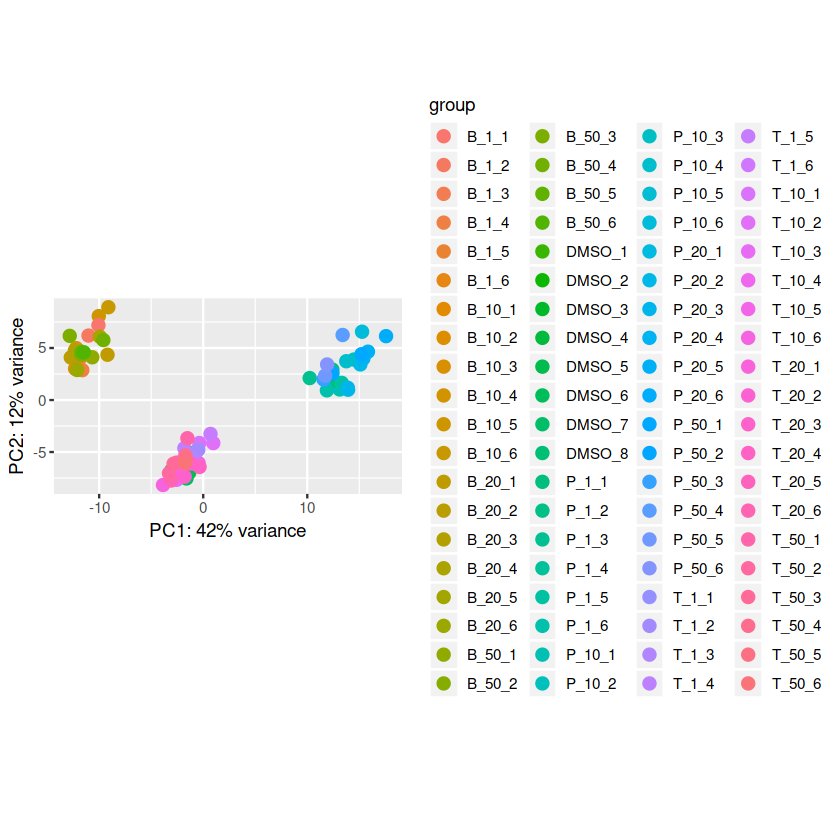

In [48]:
plotPCA(rld, intgroup="sample")

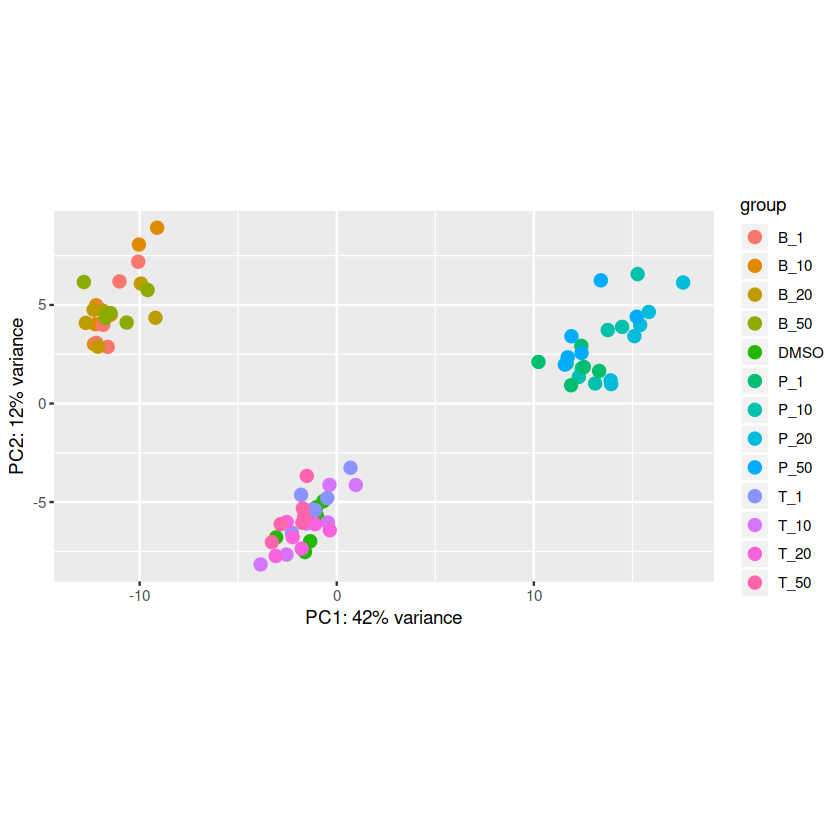

In [49]:
plotPCA(rld, intgroup="group")

### Hierarchical Clustering Heatmap
Hierarchical clustering is another method for identifying strong patterns in a dataset and potential outliers.

In [50]:
rld_mat <- assay(rld)    
### Compute pairwise correlation values
rld_cor <- cor(rld_mat)
head(rld_cor)

,B_10_1,B_10_2,B_10_3,B_10_4,B_10_5,B_10_6,B_1_1,B_1_2,B_1_3,B_1_4,⋯,T_20_3,T_20_4,T_20_5,T_20_6,T_50_1,T_50_2,T_50_3,T_50_4,T_50_5,T_50_6
B_10_1,1.0000000,0.9072116,0.9078174,0.9001604,0.8749802,0.8711992,0.8802474,0.8774338,0.8924925,0.9024612,⋯,0.8979663,0.8957119,0.8907382,0.8915245,0.8995474,0.9097450,0.9162904,0.9144501,0.9177537,0.9033778
B_10_2,0.9072116,1.0000000,0.9128407,0.9044742,0.8749544,0.8700264,0.8840197,0.8813168,0.8944233,0.9077621,⋯,0.9057887,0.9040169,0.8922870,0.8977472,0.9042840,0.9164551,0.9203686,0.9198027,0.9219712,0.9079570
B_10_3,0.9078174,0.9128407,1.0000000,0.9043907,0.8815851,0.8796357,0.8885221,0.8808983,0.8972773,0.9104517,⋯,0.9050007,0.9071811,0.8949575,0.8992901,0.9110439,0.9176056,0.9220657,0.9251231,0.9257040,0.9120552
B_10_4,0.9001604,0.9044742,0.9043907,1.0000000,0.8750715,0.8697739,0.8810066,0.8769660,0.8890052,0.9011149,⋯,0.8973995,0.8947948,0.8859359,0.8870539,0.8985233,0.9056350,0.9119746,0.9116380,0.9123600,0.9003408
B_10_5,0.8749802,0.8749544,0.8815851,0.8750715,1.0000000,0.8640496,0.8694902,0.8588991,0.8715184,0.8771038,⋯,0.8712544,0.8689910,0.8682430,0.8571925,0.8796832,0.8755315,0.8823684,0.8873223,0.8875707,0.8757415
B_10_6,0.8711992,0.8700264,0.8796357,0.8697739,0.8640496,1.0000000,0.8680073,0.8512655,0.8638105,0.8714550,⋯,0.8642045,0.8668432,0.8596688,0.8558661,0.8763221,0.8713133,0.8777122,0.8872883,0.8859009,0.8708889


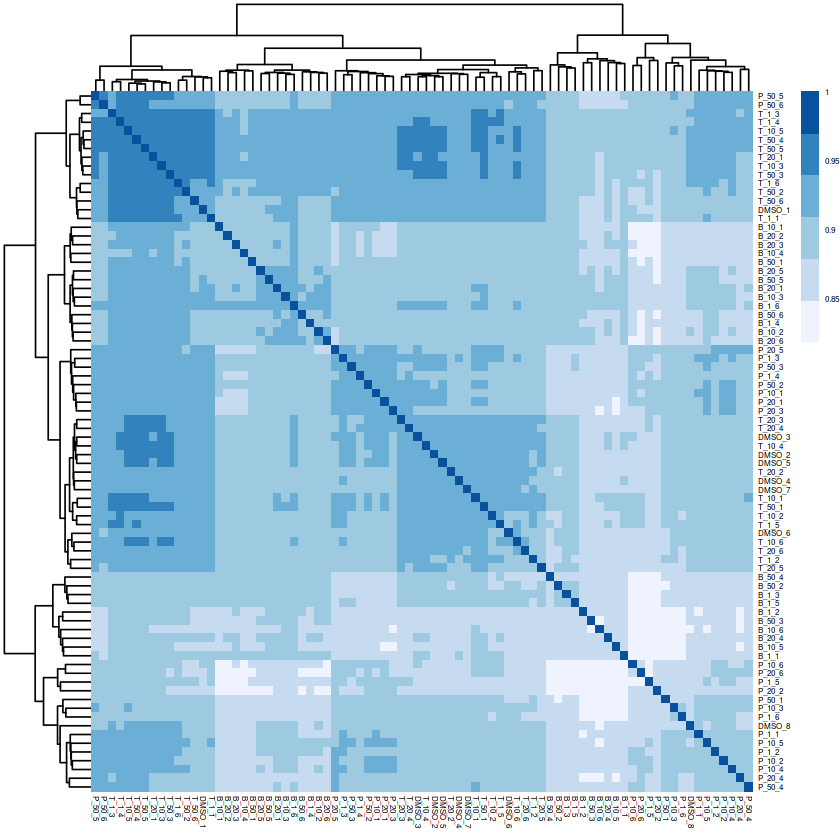

In [53]:
heat.colors <- RColorBrewer::brewer.pal(6, "Blues")
pheatmap(rld_cor,border=FALSE,fontsize = 4.5,color = heat.colors)